In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib widget

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
diffusion="5.0percent"
# diffusion="nodiff"
# file_id = "1"
file_id = "2954"
# file_id = "2638"


# hits = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_{diffusion}_filtered.h5", "MC/hits")
# hits_true = pd.read_hdf(f"../data/Trackreco/ATPC_Tl_{pressure}bar_nexus_filtered.h5", "MC/hits")


hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_smear_{file_id}.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_{pressure}bar_{diffusion}_smear_{file_id}.h5", "MC/hits")


# hits_true = pd.read_hdf(f"../data/ATPC_Tl/ATPC_Tl_1bar_nexus_2954.h5", "MC/hits")
# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_2954.h5", "MC/hits")

display(hits)

event_list = hits.event_id.unique()

eid=event_list[9]

data = hits[hits.event_id ==eid]
# data = CutandRedistibuteEnergy(data, 0.0004)

data_true = hits_true[hits_true.event_id == eid]
data_true["z"] = data_true["z"]+3000

# print(hits.event_id.unique())

,event_id,x,y,z,energy
0,103725000,2592.673340,-1528.793945,873.017334,0.000124
1,103725000,2597.432373,-1529.927490,873.632996,0.000174
2,103725000,2589.878174,-1538.342896,873.718933,0.000025
3,103725000,2591.405029,-1520.113037,873.859802,0.000174
4,103725000,2597.696289,-1521.185669,873.960510,0.000124
...,...,...,...,...,...
196629,103725059,-2560.903076,-1101.253296,1118.497925,0.003323
196630,103725059,-2566.134277,-1102.218018,1119.035522,0.000471
196631,103725059,-2559.832764,-1100.791992,1125.866943,0.000050
196632,103725059,-2554.956299,-1104.052490,1125.867065,0.000025


In [15]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, voxel_sf, Tortuosity_dist = InitializeParams(pressure, diffusion)

print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Voxel scale factor is: ",      voxel_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))
print("mean_sigma:", mean_sigma)

# Calculate the detector half-length
det_size = int(np.cbrt(6000**3/pressure)/2.0) 

# This shifts the z pos of the events so 0 is at anode
z_shift = det_size

zmin=-det_size + z_shift - mean_sigma/2 
xmin=-det_size - mean_sigma/2 
ymin=-det_size - mean_sigma/2 


Diffussion smear is:  0.29 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  4
Radius scale factor is:  7
Voxel scale factor is:  2.1
Tortuosity distance scale is: 105.0
mean_sigma: 21


In [16]:
reco_DE_event = data.copy()

# voxel size and parameters
voxel_size = mean_sigma  # mm
threshold = voxel_size*voxel_sf

df_merged = GroupHits(reco_DE_event, xmin, ymin, zmin, voxel_size, threshold)
display(df_merged)



Total groups created: 2


,event_id,x,y,z,energy,group_id
0,103725009,-1312.434692,2831.518066,2482.779053,0.000248,0
1,103725009,-1313.326904,2838.984131,2483.276855,0.000050,0
2,103725009,-1319.304565,2830.418945,2483.286621,0.000298,0
3,103725009,-1319.955200,2837.712646,2483.875244,0.000298,0
4,103725009,-1326.004272,2837.704102,2484.648682,0.000025,0
...,...,...,...,...,...,...
3582,103725009,-1094.822144,2264.347168,3741.075439,0.000025,1
3583,103725009,-1114.309692,2273.292236,3745.368896,0.000025,1
3584,103725009,-1178.128052,2430.076660,3746.526367,0.000074,1
3585,103725009,-1171.651733,2418.813721,3747.013428,0.000025,1


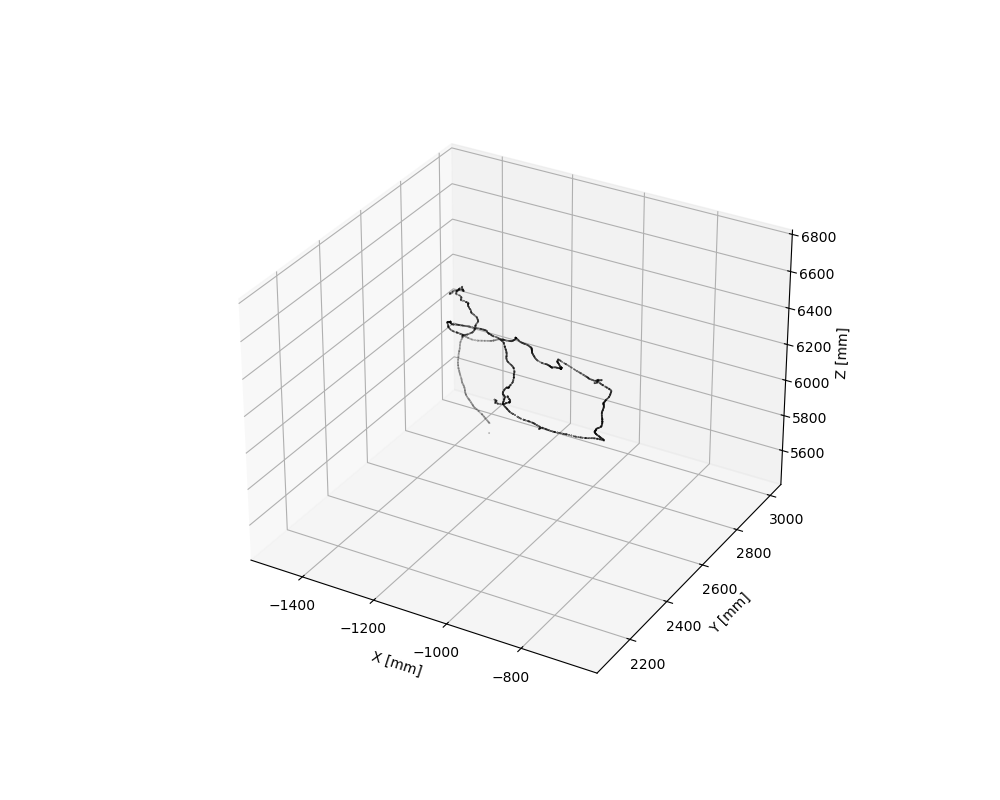

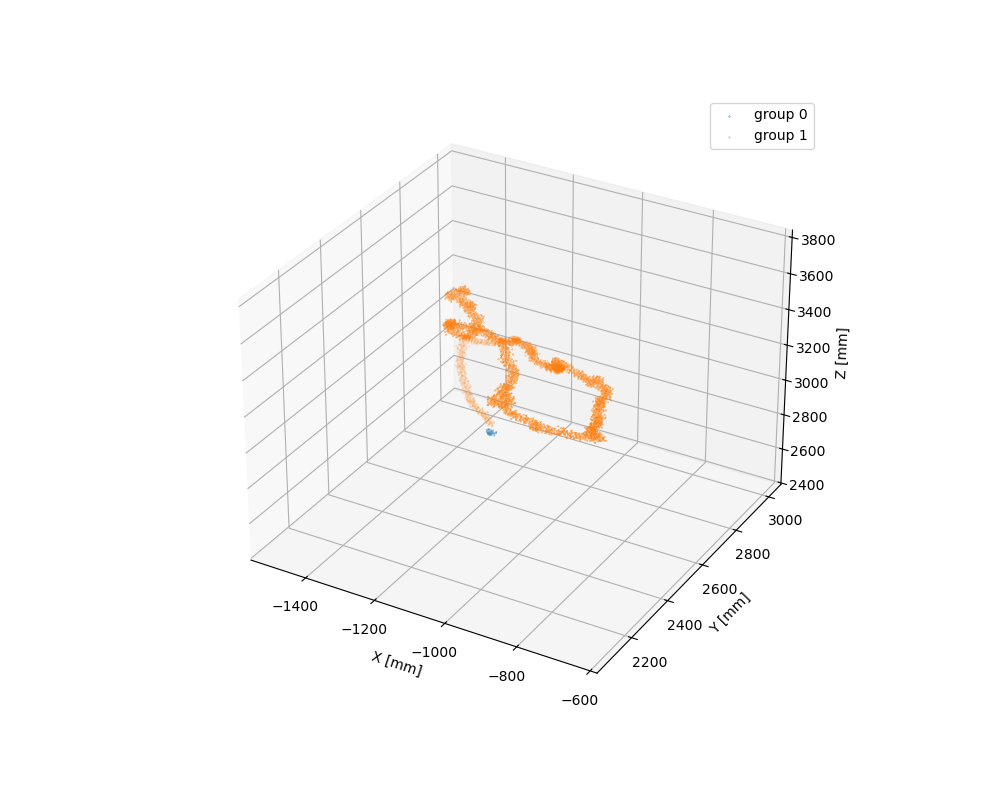

In [17]:

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(data_true['x'], data_true['y'], data_true['z'],c="k", s=0.1)
# ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

ax1.set_xlabel("X [mm]")
ax1.set_ylabel("Y [mm]")
ax1.set_zlabel("Z [mm]")


fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111, projection='3d')
for gid in sorted(df_merged["group_id"].unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    ax1.scatter(temp_df['x'], temp_df['y'], temp_df['z'], s=0.1, label = f"group {gid}")
    # ax1.scatter(data['x'], data['y'], data['z'],c="k", s=0.1)

    ax1.set_xlabel("X [mm]")
    ax1.set_ylabel("Y [mm]")
    ax1.set_zlabel("Z [mm]")
    ax1.legend()
